# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pickle

from fontTools.misc.psOperators import ps_integer
from networkx.classes import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, silhouette_score, adjusted_rand_score, rand_score, adjusted_mutual_info_score
from sklearn.metrics import mutual_info_score
from sklearn.cluster import DBSCAN

In [150]:
# Load the data
def load_features_train():
    with open(r"C:\Code\UTEC\ML\Project3\Project\data\pickle\features.pkl", "rb") as archivo:
        feature_vectors_f = pickle.load(archivo)
        video_ids_f = pickle.load(archivo)
    return feature_vectors_f, video_ids_f

In [151]:
feature_vectors, video_ids = load_features_train()

In [152]:
# Modifier to have only the ids that are in the train_subset_10.csv
train_subset_10 = pd.read_csv(r"C:\Code\UTEC\ML\Project3\Project\data\csv\train_subset_10.csv")
ids_train_subset_10 = train_subset_10["youtube_id"].values
# select the ids and labels that are in ids_train_subset_10
mod_feature_vectors = []
mod_video_ids = []
for i in range(len(video_ids)):
    if video_ids[i] in ids_train_subset_10:
        mod_feature_vectors.append(feature_vectors[i])
        mod_video_ids.append(video_ids[i])
feature_vectors = mod_feature_vectors
video_ids = mod_video_ids

In [153]:
print(len(feature_vectors))
print(len(video_ids))

5415
5415


In [154]:
# Simplify the data using the mean
X = []
for feature_vector in feature_vectors:
    try:
        X.append(np.mean(feature_vector, axis=0))
    except:
        print("Error")

C:\Users\Usuario\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Usuario\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [156]:
# Remove nan values
for i in range(len(X)):
    if np.isnan(X[i]).any():
        X.pop(i)
        video_ids.pop(i)

In [157]:
X = np.array(X)
print(X.shape)
print(len(video_ids))

(5414, 512)
5414


# Get labels

In [158]:
# get labels from train_subset.csv which contains the id and label of the videos
train_subset_labels = pd.read_csv(r"C:\Code\UTEC\ML\Project3\Project\data\csv\train_subset.csv")
# select the labels that are in video_ids
train_subset_labels = train_subset_labels[train_subset_labels["youtube_id"].isin(video_ids)]

train_subset_labels

,youtube_id,label
1,zeIkGEHK46I,riding camel
2,-Fwy8NwefTk,shot put
5,sDD0p8h88rI,dying hair
6,09AinCnKAE8,riding camel
8,qyTDZajMSqQ,baking cookies
...,...,...
10701,wJwVI6nKcqk,dying hair
10702,PGnss27GIDg,baking cookies
10706,QpKnQpqND0k,flipping pancake
10707,LDQ71GNtp28,wrapping present


In [159]:
Y_train_no_encode = []
# sort the labels to have the same order as in the feature vectors and video_ids
for video_id in video_ids:
    sort_label = train_subset_labels[train_subset_labels["youtube_id"] == video_id]["label"].values[0]
    Y_train_no_encode.append(sort_label)
    

In [160]:
# encode the lables to numbers
labelEncoder = LabelEncoder()
Y_train = labelEncoder.fit_transform(Y_train_no_encode)

In [161]:
print(Y_train.shape)

(5414,)


In [162]:
print(Y_train_no_encode[0:5])

['balloon blowing', 'balloon blowing', 'baking cookies', 'baking cookies', 'balloon blowing']


In [163]:
print(np.unique(Y_train))

[0 1 2 3 4 5 6 7 8 9]


# UMAP

In [189]:
umap_red = umap.UMAP(n_components=8)
X_umap = umap_red.fit_transform(X)

In [190]:
print(X_umap.shape)

(5414, 8)


In [40]:
# save the umap model
# with open(r"C:\Code\UTEC\ML\Project3\Project\data\pickle\x_umap.pkl", "wb") as archivo:
#         pickle.dump(X_umap, archivo)

In [41]:
# load the umap model
# with open(r"C:\Code\UTEC\ML\Project3\Project\data\pickle\x_umap.pkl", "rb") as archivo:
#         X_umap_temp = pickle.load(archivo)
# print(X_umap_temp.shape)

(10694, 30)


# DBScan

In [191]:
from sklearn.preprocessing import StandardScaler

X_umap = StandardScaler().fit_transform(X_umap)


In [167]:
dbscan = DBSCAN(eps=1.5, min_samples=4).fit(X_umap)
labels_dbscan_umap_train = dbscan.labels_

In [22]:
print(len(labels_dbscan_umap_train), len(X_umap))

10694 10694


In [23]:
print(np.unique(labels_dbscan_umap_train))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [24]:
silhouette_scr = silhouette_score(X_umap, labels_dbscan_umap_train)
adjusted_rand_scr = adjusted_rand_score(Y_train, labels_dbscan_umap_train)
mutual_info_scr = mutual_info_score(Y_train, labels_dbscan_umap_train)
print(silhouette_scr, adjusted_rand_scr, mutual_info_scr)

0.47573468 0.7288382983454574 2.479975240243041


In [149]:
ult, cult = np.unique(labels_dbscan_umap_train, return_counts=True)
print(ult, cult)

[1 2 3 4 5 6 7 8 9] [ 534  647  693  466  479  581  546 1204  264]


In [25]:
prueba = {
    'ids_train': video_ids[0:10],
    'Y_train': Y_train[0:10],
    'Y_pred' : labels_dbscan_umap_train[0:10]
}
df_prueba = pd.DataFrame(prueba)
df_prueba

,ids_train,Y_train,Y_pred
0,--gx7yb1-x0,1,0
1,--Ntf6n-j9Q,1,0
2,-07Ke73N4zI,2,1
3,-1MXpPymXFU,0,1
4,-2KvnLMnrA0,6,2
5,-36efvC2K54,0,1
6,-3tVVBhz8-o,1,0
7,-5oULXqj45c,13,3
8,-5s-IR39XaY,5,4
9,-5Vx7UtZpzk,5,4


# DBScan implementation

In [192]:
from sklearn.neighbors import KDTree
from collections import deque
class DBScan_custom:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.X = None
        self.labels = None
        
    def fit(self, X):
        self.X = X
        # load in KDtree for eficient search of neighbours
        kdtree = KDTree(X)
        # all noise
        self.labels = np.full(len(X), -1)
        # get the nn in the eps radius
        nns = kdtree.query_radius(X, r=self.eps)
        # iterate trough all the points to find the clusters
        cluster_number = 0
        visited_points = np.zeros(len(X))
        for i in range(len(X)):
            # skip if the point is already assigned to a cluster
            if self.labels[i] != -1:
                continue
            visited_points[i] = 1
            # core points
            if len(nns[i]) >= self.min_samples:
                cluster_number += 1
                # assign the cluster number to the current point if doesnt have a cluster
                if self.labels[i] == -1:
                    self.labels[i] = cluster_number
                # expand the cluster from the current point to its nns
                nns_p = deque(nns[i])
                j = nns_p.pop()
                # iterate through all the nns and assign the same cluster number
                while True:
                    if visited_points[j] == 0:
                        visited_points[j] = 1
                        nns_nn_p = nns[j]
                        if nns_nn_p.size >= self.min_samples:
                            for item in nns_nn_p:
                                nns_p.append(item)
                    if self.labels[j] == -1:
                        self.labels[j] = cluster_number
                    # break if there are no more nns cores
                    if len(nns_p) == 0:
                        break
                    j = nns_p.pop()
        return self
    def labels_(self):
        return self.labels
    def predict(self, X_test):
        # return the label of the nn of the train points
        labels = []
        kdtree = KDTree(self.X)
        dist, nns_1 = kdtree.query(X_test, k=1)
        for i in range(len(nns_1)):
            labels.append(self.labels[nns_1[i][0]])
        return labels

        

In [193]:
dbscan = DBScan_custom(eps=1.5, min_samples=4).fit(X_umap)
labels_dbscan_umap_train = dbscan.labels_()

In [194]:
print(len(labels_dbscan_umap_train))

5414


In [195]:
print(np.unique(labels_dbscan_umap_train))

[1 2 3 4 5 6 7 8]


In [196]:
def metrics_clustering(X, Y_true, Y_pred):
    silhouette_scr = silhouette_score(X, Y_pred)
    rand_scr = rand_score(Y_true, Y_pred)
    adj_mutual_info_scr = adjusted_mutual_info_score(Y_true, Y_pred)
    return silhouette_scr, rand_scr, adj_mutual_info_scr

In [197]:
silhouette_scr, rand_scr, mutual_info_scr= metrics_clustering(X_umap, Y_train, labels_dbscan_umap_train)
print(silhouette_scr, rand_scr, mutual_info_scr)

0.8061307 0.9488584276070325 0.9085740182169194


In [ ]:
# Find the best parameters for DBScan
# TODO:  apply the model to the test data, submit the results

In [123]:
# Find the best parameters for DBScan
def best_params_dbscan(X, Y_true, eps_values, min_samples_values):
    metric_s = []
    for eps_value in eps_values:
        for min_samples_value in min_samples_values:
            print(eps_value, min_samples_value)
            dbscan = DBScan_custom(eps=eps_value, min_samples=min_samples_value).fit(X)
            Y_pred = dbscan.labels_()
            silhouette_scr, rand_scr, adj_mutual_info_scr = metrics_clustering(X, Y_true, Y_pred)
            metric_s.append([eps_value, min_samples_value, silhouette_scr, rand_scr, adj_mutual_info_scr])
    return metric_s

In [187]:
eps_values = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
min_samples_values = [2, 3, 4, 5, 6, 7, 8]
metrics_search = best_params_dbscan(X_umap, Y_train, eps_values, min_samples_values)

0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.5 2
0.5 3
0.5 4
0.5 5
0.5 6
0.5 7
0.5 8
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1.5 2
1.5 3
1.5 4
1.5 5
1.5 6
1.5 7
1.5 8
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2.5 2
2.5 3
2.5 4
2.5 5
2.5 6
2.5 7
2.5 8
3 2
3 3
3 4
3 5
3 6
3 7
3 8


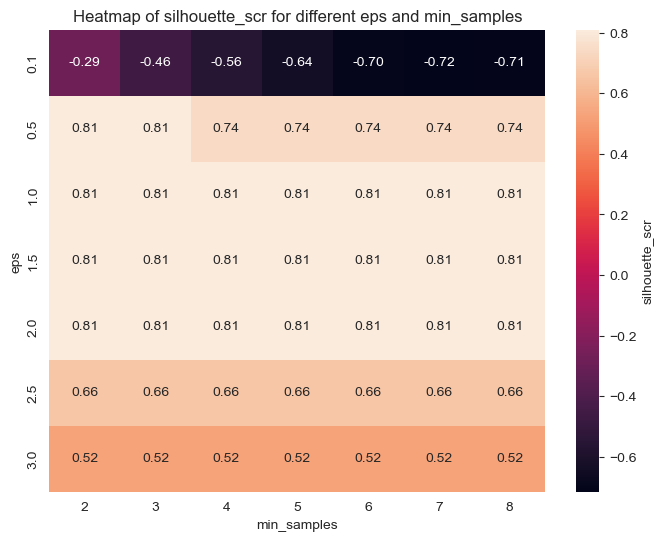

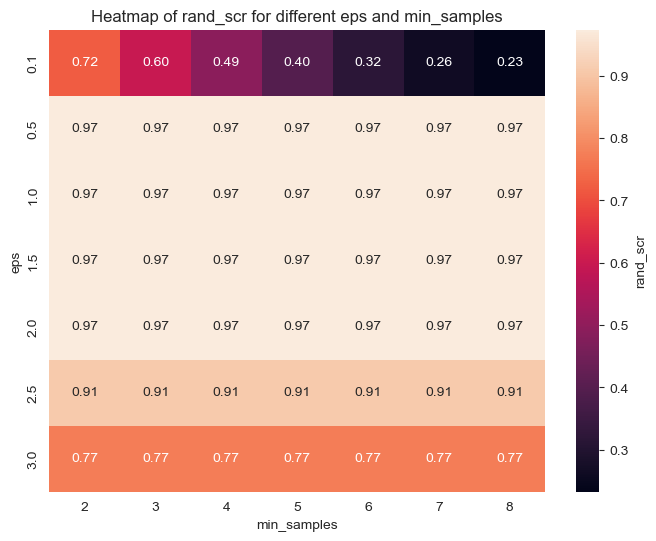

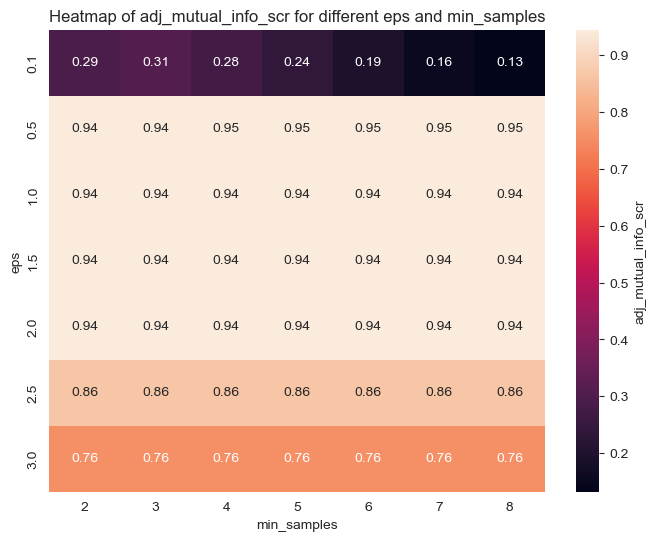

In [188]:
# graph the rsultas of the grid search
df_metric_search = pd.DataFrame(metrics_search, columns=["eps", "min_samples", "silhouette_scr", "rand_scr", "adj_mutual_info_scr"])

for metric in ["silhouette_scr", "rand_scr", "adj_mutual_info_scr"]:
    heatmap_data = df_metric_search.pivot(index="eps", columns="min_samples", values=metric)
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cbar_kws={'label': metric})
    plt.title(f"Heatmap of {metric} for different eps and min_samples")
    plt.xlabel("min_samples")
    plt.ylabel("eps")
    plt.show()


### Segun los graficos los mejores parametros son eps=1 y min_samples = [2:8], se escoge min_samples = 4

# Assign acctions to the labels based on majority voting (Train)

In [126]:
import statistics
def actions_dictionary(labels, Y):
    unique_labels = np.unique(labels)
    action_dict = {}
    for label in unique_labels:
        index_labels = np.where(labels == label)[0]
        actions_string = [Y[i] for i in index_labels] 
        action_majority = statistics.mode(actions_string)
        action_dict[label] = action_majority
    return action_dict
        
        

In [174]:
train_dictionary_actions = actions_dictionary(labels_dbscan_umap_train, Y_train_no_encode)

In [175]:
print(train_dictionary_actions)

{1: 'balloon blowing', 2: 'baking cookies', 3: 'shot put', 4: 'flipping pancake', 5: 'riding camel', 6: 'wrapping present', 7: 'stretching leg', 8: 'dying hair', 9: 'spraying'}


In [129]:
print(type(train_dictionary_actions))

<class 'dict'>


In [130]:
# Decode the actions
def decode_labels(labels, dictionary):
    decoded_labels = []
    for label in labels:
        decoded_labels.append(dictionary[label])
    return decoded_labels

# Load Data test

In [176]:
def load_features_test():
    with open(r"C:\Code\UTEC\ML\Project3\Project\data\pickle\features_test.pkl", "rb") as archivo:
        feature_vectors_test_f = pickle.load(archivo)
        video_ids_test_f = pickle.load(archivo)
    return feature_vectors_test_f, video_ids_test_f

In [177]:
feature_vectors_test, video_ids_test = load_features_test()

In [198]:
X_test = []
for feature_vector in feature_vectors_test:
    try:
        X_test.append(np.mean(feature_vector, axis=0))
    except:
        print("Error")

In [199]:
for i in range(len(X_test)):
    if np.isnan(X_test[i]).any():
        X_test.pop(i)
        video_ids_test.pop(i)

In [180]:
X_test = np.array(X_test)
print(X_test.shape)
print(len(video_ids_test))

(1626, 512)
1626


# Apply the best model of DBScan-UMAP to the test data

In [200]:
umap_red = umap.UMAP(n_components=8)
X_test_umap = umap_red.fit_transform(X_test)
X_test_umap = StandardScaler().fit_transform(X_test_umap)


In [201]:
print(X_test_umap.shape)

(1626, 8)


In [202]:
dbscan = DBScan_custom(eps=1, min_samples=4).fit(X_umap)
Y_test_pred = dbscan.predict(X_test_umap)

In [203]:
print(Y_test_pred[0:10])

[7, 2, 8, 7, 1, 8, 1, 6, 8, 6]


In [140]:
Y_test_pred_string = decode_labels(Y_test_pred, train_dictionary_actions)

In [204]:
lu, clu = np.unique(Y_test_pred, return_counts=True)
print(lu, clu)

[1 2 4 6 7 8 9] [122 354   5 351  65 650  79]


In [205]:
prueba2 = { "youtube_id": video_ids_test, "label": Y_test_pred}
df_prueba2 = pd.DataFrame(prueba2)
df_prueba2

,youtube_id,label
0,-3T2VPGo2jI,7
1,-7Wz9S-ZZz4,2
2,-a1f1ikmdd8,8
3,-AZMzKjls-k,7
4,-bGVnGCy2yY,1
...,...,...
1621,Ztyij17ill0,7
1622,zujZagp-4jQ,8
1623,ZuvChCAjbak,8
1624,ZxpwgIZg4lI,8


In [206]:
# Save the results as csv
df_prueba2.to_csv(r"C:\Code\UTEC\ML\Project3\Project\data\csv\submission.csv", index=False)

In [207]:
test_subset_10 = pd.read_csv(r"C:\Code\UTEC\ML\Project3\Project\data\csv\test_subset_10.csv")
ids_test_subset_10 = test_subset_10["youtube_id"].values
# select the ids and labels that are in ids_test_subset_10
df_prueba2_subset = df_prueba2[df_prueba2["youtube_id"].isin(ids_test_subset_10)]
print(df_prueba2_subset.head(5))

    youtube_id  label
1  -7Wz9S-ZZz4      2
2  -a1f1ikmdd8      8
4  -bGVnGCy2yY      1
5  -BrNqmFy-6Y      8
6  -CsBjy8T-II      1


In [208]:
print(len(df_prueba2_subset.values))

805


In [209]:
# Save the results as csv
df_prueba2_subset.to_csv(r"C:\Code\UTEC\ML\Project3\Project\data\csv\submission_subset.csv", index=False)